In [2]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import requests
import seaborn as sns
import torch
from datasets import load_dataset
from PIL import Image
from transformers import ASTConfig, ASTFeatureExtractor, ASTModel, CLIPModel, CLIPProcessor


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
dataset = load_dataset("DavidVivancos/MindBigData2022_MNIST_IN")


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
list(dataset["train"][0].items())[:8]


[('label', 6),
 ('AF3-0', 4284.102564),
 ('AF3-1', 4281.073718),
 ('AF3-2', 4296.923077),
 ('AF3-3', 4312.588141),
 ('AF3-4', 4318.141025),
 ('AF3-5', 4314.20673),
 ('AF3-6', 4296.65064)]

In [9]:
channels = sorted(set(map(lambda x: x.split("-")[0], dataset["train"][0].keys())) - {'label'})
channels
# ?


['AF3', 'AF4', 'PZ', 'T7', 'T8']

In [77]:
def preprocess(inputs):
  outputs = {}
  outputs["label"] = inputs["label"]
  # prealloc numpy arrays
  sample = np.zeros((len(channels), 256))
  for channel in channels:
    sample_tensor = np.array(inputs[channel])
    standardized_sample = (sample_tensor - means[channel]) / stds[channel]
    sample[channels.index(channel)] = standardized_sample
  features = []
  # prealloc
  for channel in channels:
    n_fft = 46
    D = librosa.stft(standardized_sample, n_fft=n_fft)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    features.append(?)
  outputs["pixel_values"] = torch.stack(features, 1)
  return outputs


In [78]:
pixel_values = preprocess(sample_tensor)["pixel_values"]
# batch_size, num_channels, height, width)


In [259]:
standardized_sample = (sample_tensor["PZ"] - means["PZ"]) / stds["PZ"]


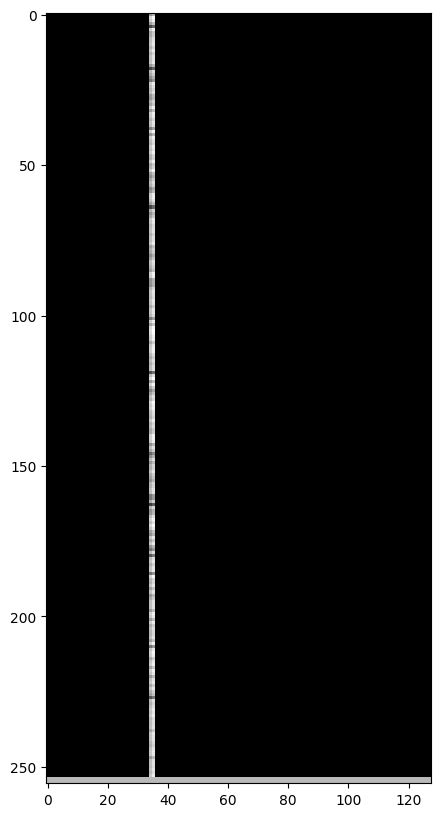

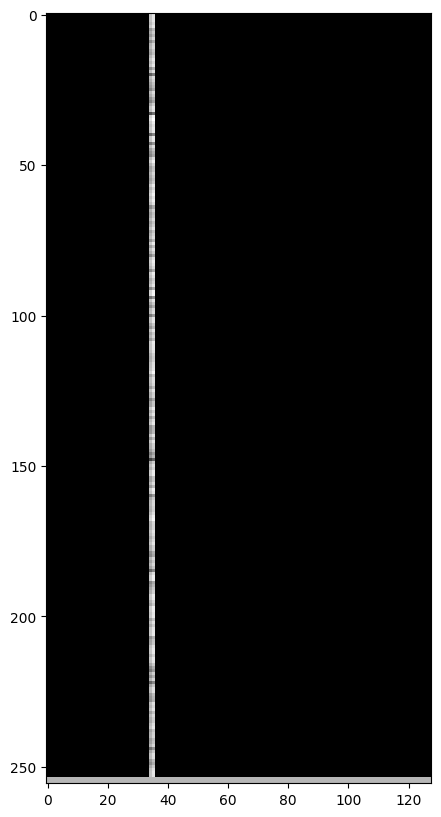

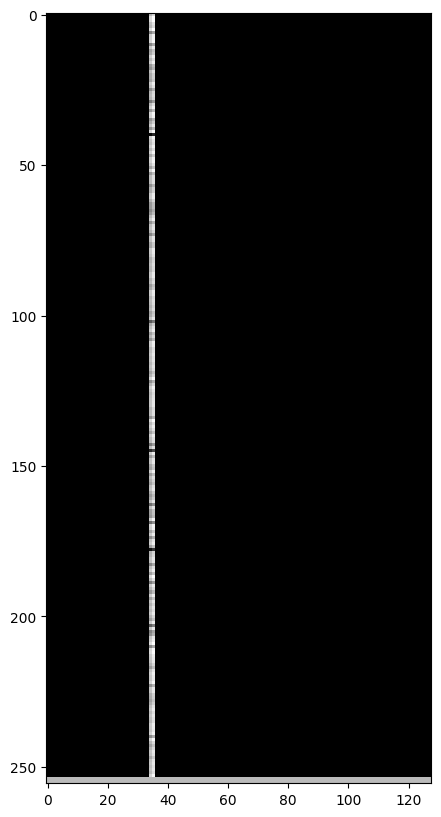

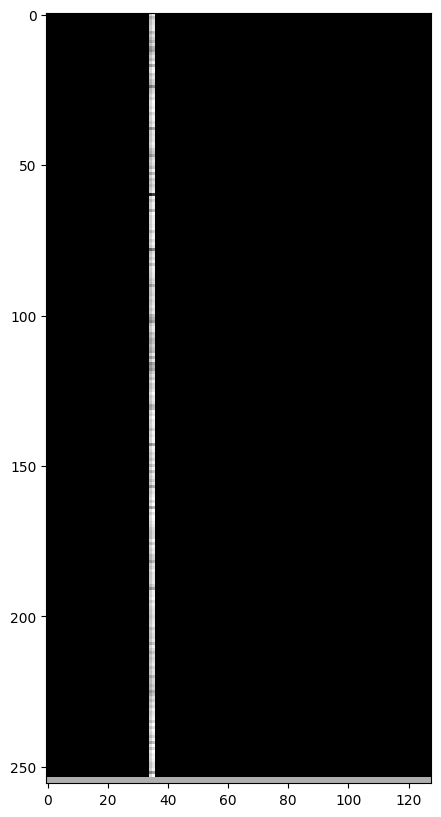

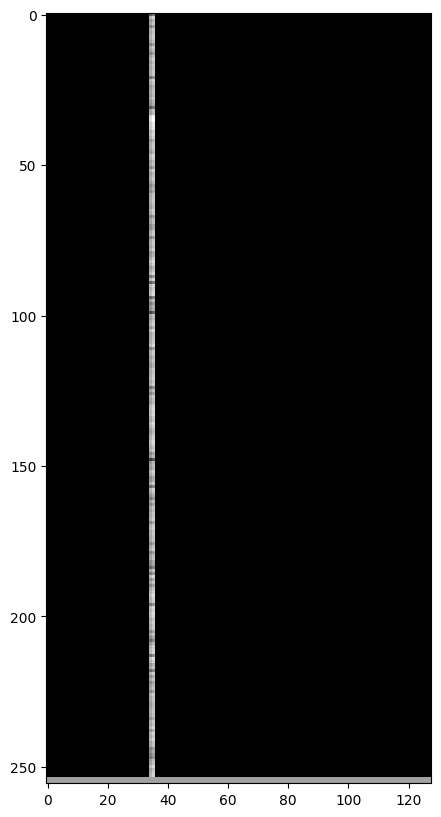

In [266]:

for channel in range(pixel_values.shape[1]):
  plt.figure(figsize=(10, 10))
  plt.imshow(pixel_values[0, channel].numpy(), cmap="gray")
  plt.show()


In [ ]:

# Initializing a AST MIT/ast-finetuned-audioset-10-10-0.4593 style configuration
configuration = ASTConfig()

# Initializing a model (with random weights) from the MIT/ast-finetuned-audioset-10-10-0.4593 style configuration
model = ASTModel(configuration)

# Accessing the model configuration
configuration = model.config


In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

urls = [
  "http://images.cocodataset.org/val2017/000000039769.jpg",
  "https://farm3.staticflickr.com/2674/5850229113_4fe05d5265_z.jpg",
]
images = [Image.open(requests.get(url, stream=True).raw) for url in urls]

texts = ["cat", "dog"]
inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)

outputs = model(**inputs, return_loss=True)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
